In [35]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.1.0'

In [36]:
!pip install pycocotools

In [37]:
!git clone --depth 1 https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


In [0]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [39]:
%%bash 
cd models/research
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1017522 sha256=6e9a6f9f889a6f786902af5e71df7cc0eeccba4e816c30d268467e411e9cc471
  Stored in directory: /tmp/pip-ephem-wheel-cache-jyy2c6ji/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [41]:
! pip install tensorflow-object-detection-api

In [0]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
# patch tf1 into `utils.ops`
utils_ops.tensorflow = tensorflow.compat.v1

# Patch the location of gfile
tensorflow.gfile = tensorflow.io.gfile

# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Change current working directory to project folder (1 mark)

In [0]:
%%bash
cd "/content/drive/My Drive/ComputerVisionProjectData/ObjDetection/"

### Load the "images.npy" file (4 marks)
- This file contains images with details of bounding boxes

In [0]:
import numpy as np
data = np.load('/content/drive/My Drive/ComputerVisionProjectData/ObjDetection/images.npy', allow_pickle=True)

In [47]:
data.shape

(409, 2)

### Check one sample from the loaded "images.npy" file  (4 marks)

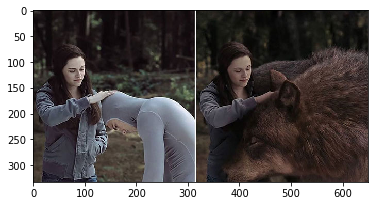

In [48]:
from matplotlib import pyplot as plt

plt.imshow(data[0][0])
plt.show()

### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (1 mark)

In [51]:
#### Add your code here ####
X_train.shape

(409, 224, 224, 3)

In [52]:
#### Add your code here ####
masks.shape

(409, 224, 224)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

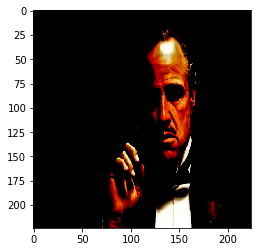

In [53]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])
pyplot.show()

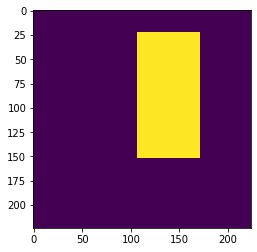

In [54]:
%matplotlib inline
pyplot.imshow(masks[n])

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model


def create_model(trainable=True):
    IMG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    #ref https://keras.io/applications/#mobilenet
    model = MobileNet(input_shape=IMG_SHAPE, alpha = 1.0, include_top=False, weights='imagenet')
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    #ref https://stackoverflow.com/questions/59154560/how-can-i-feed-the-output-from-last-layer-of-mobilenet-to-a-unet-model
    block0 = model.get_layer("conv_pw_1_relu").output 
    block = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block])
 #   x = Concatenate()([UpSampling2D()(x), block0])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function

In [56]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()
#model.name="MobileNetUnet"

# Print summary
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient


In [0]:
def dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tensorflow.keras.backend.flatten(y_true)
    y_pred_f = tensorflow.keras.backend.flatten(y_pred)
    intersection = tensorflow.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tensorflow.keras.backend.sum(y_true_f) + tensorflow.keras.backend.sum(y_pred_f) + smooth)

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (5 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [0]:
adam = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
model.compile(adam, loss=loss, metrics=[dice_coefficient])

### Define checkpoint and earlystopping

In [79]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (5 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [83]:
model.fit(x=X_train, y=masks, batch_size=1, epochs=20, verbose=1, callbacks=[reduce_lr , checkpoint, stop], workers=1, use_multiprocessing=True)

Train on 409 samples
Epoch 1/20
408/409 [============================>.] - ETA: 0s - loss: 0.3147 - dice_coefficient: 0.8161
Epoch 00001: loss did not improve from 0.26537
409/409 [==============================] - 24s 58ms/sample - loss: 0.3146 - dice_coefficient: 0.8161
Epoch 2/20
408/409 [============================>.] - ETA: 0s - loss: 0.3273 - dice_coefficient: 0.8110
Epoch 00002: loss did not improve from 0.26537
409/409 [==============================] - 21s 52ms/sample - loss: 0.3272 - dice_coefficient: 0.8110
Epoch 3/20
124/409 [========>.....................] - ETA: 14s - loss: 0.2939 - dice_coefficient: 0.8235
Epoch 00003: loss did not improve from 0.26537


KeyboardInterrupt: ignored

### Get the predicted mask for a sample image   (5 marks)

In [95]:
model.input_shape

(None, 224, 224, 3)

In [96]:
model.output_shape

(None, 224, 224)

In [100]:
X_train.shape

(409, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


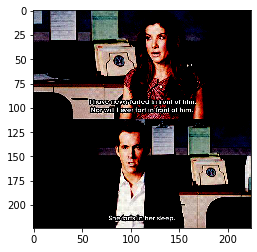

In [138]:
n = 5
sample_image = X_train[n]
final_image = sample_image
sample_image.shape
pyplot.imshow(sample_image)

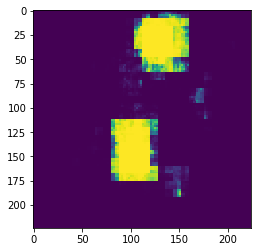

In [139]:
sample_image = np.resize(sample_image, (1, 224, 224, 3))
sample_image.shape
pred_mask = model.predict(x=sample_image)
pred_mask = np.resize(pred_mask, (224, 224))
pyplot.imshow(pred_mask)

### Impose the mask on the image (5 marks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


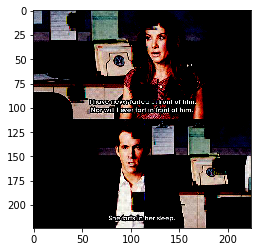

In [156]:
final_pred_mask = np.resize(pred_mask, (224,224,3))
final_image = np.resize(sample_image,  (224,224,3)) - final_pred_mask
pyplot.imshow(final_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


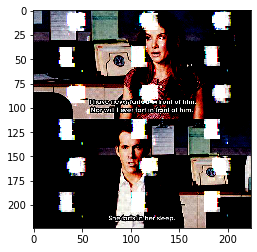